In [1]:
import numpy as np
from numpy import random
from scipy.stats import norm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [41]:
class iFusion:

    def __init__(self, bandwidth = None, bandwidth_path = np.arange(0.01, 5, 0.01), boot_times = 500, cv_num = 5, early_stopping_rounds = None, epsilon = 0.1, kernel = "uniform", loss_func = "mse", screen_prop = None, tau = -1/3, weight_vector = None):
        self.params = {
            "boot_times": boot_times,
            "cv_num": cv_num,
            "early_stopping_rounds": early_stopping_rounds if early_stopping_rounds is not None else len(bandwidth_path),
            "epsilon": epsilon,
            "loss_func": loss_func,
            "screen_prop": screen_prop,
            "kernel": kernel,
            "tau": tau,
            "bandwidth_path": bandwidth_path
        }            
        self.bandwidth = bandwidth
        self.weight_vector = weight_vector
        self.boot_corr = None
        self.X = None
        self.y = None
        
    def _loadData(self, X, y):
        """
        Load data            
        """
        if self.X is None or self.y is None:
            self.X = X
            self.y = y
            self.n = np.array([len(x) for x in X])
            self.n_total = sum(self.n)
            self.K = len(X)
            assert(len(set(X[k].shape[1] for k in range(self.K))) == 1)
            self.p = X[0].shape[1]
               
        
    def _indivCD(self, X, y):
        """
        Compute individual CD
        """
        n, p = X.shape
        M = np.linalg.inv(X.T.dot(X))
        indiv_mean = M.dot(X.T).dot(y)
        indiv_cov = np.sum(np.square(y - X.dot(indiv_mean))) / (n - p) * M
        return indiv_mean, indiv_cov

    
    def _combineCD(self, indiv_mean_all, indiv_cov_all, weight_vector):
        """
        Combine individual CDs into a combined CD given weight vector
        """
        tmp1, tmp2, tmp3 = np.zeros((self.p, self.p)), np.zeros(self.p), np.zeros((self.p, self.p))
        for k, w in enumerate(weight_vector):
            if w != 0:
                tmp0 = np.linalg.inv(indiv_cov_all[k, :, :])
                tmp1 += w * tmp0
                tmp2 += w * tmp0.dot(indiv_mean_all[k, :])
                tmp3 += w ** 2 * tmp0
        tmp4 = np.linalg.inv(tmp1)
        comb_mean, comb_cov = tmp4.dot(tmp2), tmp4.dot(tmp3).dot(tmp4)
        return comb_mean, comb_cov


    def _weightVector(self, indiv_mean_all, indiv_cov_all, n, bandwidth):
        """
        Compute screen weight vector given bandwidth parameter(s)        
        """
        bandwidth = np.array([bandwidth]).flatten()            
        dist = float("inf") * np.ones((len(bandwidth), self.K))
        keep = range(self.K)
        n_hm = 2 * n[self.target_id] * n / (n[self.target_id] + n)
        
        if self.params["screen_prop"] is not None:
            dist_est = np.apply_along_axis(lambda x: np.sum((x - indiv_mean_all[self.target_id, :]) ** 2), 1, indiv_mean_all)
            keep, = np.where(dist_est <= np.percentile(dist_est, self.params["screen_prop"] * 100, interpolation="higher"))
        for k in keep:
            tmp = np.sqrt((indiv_mean_all[self.target_id, :] - indiv_mean_all[k, :]).T.dot(np.linalg.inv(indiv_cov_all[self.target_id, :, :] + indiv_cov_all[k, :, :])).dot(indiv_mean_all[self.target_id, :] - indiv_mean_all[k, :])) / (n_hm[k] * self.p) / n_hm[k] ** self.params["tau"]
            dist[:, k] = tmp / bandwidth
                        
        if self.params["kernel"] == "uniform":
            weight_vector = 1 * (np.abs(dist) <= 1)
        elif self.params["kernel"] == "epanechnikov":
            weight_vector = (1 - dist ** 2) * np.where(np.abs(dist) <= 1, 1, 0)
        elif self.params["kernel"] == "quartic":
            weight_vector = (1 - dist ** 2) ** 2 * np.where(np.abs(dist) <= 1, 1, 0)
        elif self.params["kernel"] == "gaussian":
            weight_vector = np.exp(-dist ** 2 / 2)
        
        if len(bandwidth) == 1:
            return weight_vector[0]
        return weight_vector
    
    
    def _tuneBandwidth(self):
        """
        Tune bandwidth parameter based on cross-validation        
        """ 
        bandwidth_path_len = len(self.params["bandwidth_path"])
        loss = float("inf") * np.ones((bandwidth_path_len, self.params["cv_num"]))
        loss_mean = []
        loss_std = []
        
        kf = KFold(n_splits = self.params["cv_num"])  
        kf_splits = [kf.split(self.X[k], self.y[k]) for k in range(self.K)]
        
        indiv_mean_all_cv = np.zeros((bandwidth_path_len, self.K, self.p))
        indiv_cov_all_cv = np.zeros((bandwidth_path_len, self.K, self.p, self.p))
        X_target_test, y_target_test = [], []                                          
        for k, kf_split in enumerate(kf_splits):
            fold = 0                        
            for train_index, test_index in kf_split:
                indiv_mean_all_cv[fold, k, :], indiv_cov_all_cv[fold, k, :, :] = self._indivCD(self.X[k][train_index, :], self.y[k][train_index])     
                fold += 1
                if k == self.target_id:
                    X_target_test.append(self.X[k][test_index, :])
                    y_target_test.append(self.y[k][test_index])
                                
        weight_vector_all = np.zeros((self.params["cv_num"], bandwidth_path_len, self.K))
        for fold in range(self.params["cv_num"]):
            weight_vector_all[fold, :, :] = self._weightVector(indiv_mean_all_cv[fold, :, :], indiv_cov_all_cv[fold, :, :, :], self.n * (self.params["cv_num"] - 1) / self.params["cv_num"], self.params["bandwidth_path"])
                                         
        for i in range(bandwidth_path_len):
            for fold in range(self.params["cv_num"]):
                comb_mean_new, _ = self._combineCD(indiv_mean_all_cv[fold, :, :], indiv_cov_all_cv[fold, :, :, :], weight_vector_all[fold, i, :])
                if self.params["loss_func"] == "mse":
                    loss[i, fold] = np.mean((y_target_test[fold] - X_target_test[fold].dot(comb_mean_new)) ** 2)
                elif self.params["loss_func"] == "mae":
                    loss[i, fold] = np.mean(np.abs(y_target_test[fold] - X_target_test[fold].dot(comb_mean_new)))
            loss_mean.append(np.mean(loss[i, :]))
            loss_std.append(np.std(loss[i, :]) / np.sqrt(self.params["cv_num"]))            
            if i == 0:
                count = 0
                loss_min = loss_mean[0]
            if loss_min >= loss_mean[i]:
                loss_min = loss_mean[i]
                loss_min_std = loss_std[i]
                count = 0
            buffer = self.params["epsilon"] * loss_min_std
            if loss_mean[i] > loss_min + buffer:
                count += 1
            if count >= self.params["early_stopping_rounds"]:
                break
                    
        i_min, = np.where(loss_mean == loss_min)
        i_min = i_min[0]
        i_opt = np.where(loss_mean <= loss_mean[i_min] + self.params["epsilon"] * loss_std[i_min])
        i_opt = int(np.floor(np.median(i_opt)))
        
        self.loss_mean, self.loss_std, self.bandwidth = loss_mean, loss_std, self.params["bandwidth_path"][i_opt]
    
                           
    def fit(self, X, y, target_id):
        """
        Main function
        """                                  
        # load data        
        self._loadData(X, y)

        # compute individual CDs
        self.indiv_mean_all = np.zeros((self.K, self.p))
        self.indiv_cov_all = np.array([np.identity(self.p) for _ in range(self.K)])
        for k in range(self.K):
            self.indiv_mean_all[k, :], self.indiv_cov_all[k, :, :] = self._indivCD(self.X[k], self.y[k])

        # set target
        self.target_id = target_id    
        
        # tune weight vector
        if self.weight_vector is None:
            if self.bandwidth is None:
                self._tuneBandwidth()
            self.weight_vector = self._weightVector(self.indiv_mean_all, self.indiv_cov_all, self.n, self.bandwidth)

        # combine CDs
        self.comb_mean, self.comb_cov = self._combineCD(self.indiv_mean_all, self.indiv_cov_all, self.weight_vector)  
        
        
    def plotTuning(self):
        """
        Plot the cross validated loss versus the bandwidth
        
        """
        n = len(self.loss_mean)
        plt.figure(1, figsize=(6, 4))
        plt.errorbar(self.params["bandwidth_path"][:n], self.loss_mean, fmt='ro', label="data",xerr=0, yerr=list(np.array(self.params["epsilon"]) * np.array(self.loss_std)), ecolor='black', ms=2)
        plt.xlabel('bandwidth')
        plt.ylabel('cross validated loss')
        
        
    def getMean(self, type = "indiv"):
        if type == "indiv":
            return self.indiv_mean_all[self.target_id, :]
        elif type == "comb":
            return self.comb_mean
        elif type == "boot":
            if self.boot_corr is None:
                self._bootCorrect(0.05)                            
            return self.comb_mean - self.boot_corr["bias_corr"]
        
    def getCI(self, type = "indiv", alpha = 0.05):
        """
        Get confidence interval using individual CD 
        """
        
        if type == "indiv":
            mean = self.indiv_mean_all[self.target_id, :]
            var = self.indiv_cov_all[self.target_id, :, :].diagonal()        
        elif type == "comb":
            mean = self.comb_mean
            var = self.comb_cov.diagonal()
        elif type == "boot":
            if self.boot_corr is None:
                self._bootCorrect(alpha)                            
            mean = self.comb_mean
            var = self.comb_cov.diagonal() * self.boot_corr["ci_corr"]

        return mean - norm.ppf(1 - alpha / 2) * np.sqrt(var), mean + norm.ppf(1 - alpha / 2) * np.sqrt(var)
        
                
    def _bootCorrect(self, alpha = 0.05):
        """
        Correct confidence intervals from combined CD based on bootstrap
        """
        
        comb_mean_boot = np.zeros((self.params["boot_times"], self.p))
        comb_cov_boot = np.zeros((self.params["boot_times"], self.p, self.p))
        
        for b in range(self.params["boot_times"]):
            index = [np.random.choice(range(n), n) for n in self.n]
            X_boot = [self.X[k][index[k], :] for k in range(self.K)]
            y_boot = [self.y[k][index[k]] for k in range(self.K)]
            indiv_mean_boot = np.zeros((self.K, self.p))
            indiv_cov_boot = np.zeros((self.K, self.p, self.p))
            for k in range(self.K):
                indiv_mean_boot[k, :], indiv_cov_boot[k, :, :] = self._indivCD(X_boot[k], y_boot[k])
            comb_mean_boot[b, :] , comb_cov_boot[b, :, :] = self._combineCD(indiv_mean_boot, indiv_cov_boot, self.weight_vector)
        
        bias_corr = np.zeros(self.p)
        ci_corr = np.ones(self.p)        
        for j in range(self.p):
            bias_corr[j] = np.mean(comb_mean_boot[:, j]) - self.indiv_mean_all[self.target_id, j]
            for corr in np.arange(1, 2, 0.01):
                ci_low = comb_mean_boot[:, j] - norm.ppf(1 - alpha / 2) * corr * np.sqrt(comb_cov_boot[:, j, j])
                ci_up = comb_mean_boot[:, j] + norm.ppf(1 - alpha / 2) * corr * np.sqrt(comb_cov_boot[:, j, j])
                coverage = np.mean((ci_low <= self.indiv_mean_all[self.target_id, j]) * (ci_up >= self.indiv_mean_all[self.target_id, j]))
                if coverage >= 1 - alpha:
                    ci_corr[j] = corr
                    break
                    
        self.boot_corr = {"ci_corr": ci_corr, "bias_corr": bias_corr}


In [62]:
# simulation I
nk = 40
X = [np.ones((nk, 1)) for _ in range(9)]
d = 3 * nk ** (-1/6)
y = []
for k in range(3):
    y.append(random.randn(nk))
for k in range(3, 6):
    y.append(d + (k - 4) / nk + random.randn(nk))
for k in range(6, 9):
    y.append((k - 4) * d + random.randn(nk))

m = iFusion(cv_num = 5, early_stopping_rounds = 10, epsilon = 0.5, loss_func="mae")
m.fit(X, y, 0)
print(m.weight_vector)
print(m.bandwidth)

[1 1 1 0 0 0 0 0 0]
0.33


In [64]:
print(m.getMean("indiv"))
print(m.getMean("comb"))
print(m.getMean("boot"))
print(m.getCI("indiv"))
print(m.getCI("comb"))
print(m.getCI("boot"))

[0.12907153]
[0.0458265]
[0.12438718]
(array([-0.17409637]), array([0.43223944]))
(array([-0.12940604]), array([0.22105904]))
(array([-0.1531994]), array([0.2448524]))


[1 1 1 0 0 0 0 0 0]
0.3


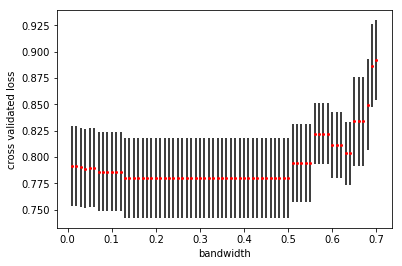

In [44]:
m.plotTuning()
print(m.weight_vector)
print(m.bandwidth)

In [67]:
# simulation I
nk = 40
X = [np.ones((nk, 1)) for _ in range(9)]
d = 3 * nk ** (-1/6)
R = 500
p = 1


est = np.zeros((R, 3, 7, p))
coverage = np.zeros((R, 3, 7, p))
width = np.zeros((R, 3, 7, p))
target_ids = [0]

random.seed(0)  
thetas = [0, 0, 0, d - 1 / nk, d, d + 1 / nk, 2 * d, 3 * d, 4 * d]

def oracleWeightVector(target_id):
    if target_id in [0,1,2]:
        weight_vector = np.array([1,1,1,0,0,0,0,0,0])
    elif target_id in [3,4,5]:
        weight_vector = np.array([0,0,0,1,1,1,0,0,0])
    elif target_id in [6,7,8]:
        weight_vector = np.zeros(9)
        weight_vector[target_id] = 1
    return weight_vector
    

    
random.seed(1)   
for i in range(R):
    y = []
    for k in range(9):
        y.append(thetas[k] + random.randn(nk))
        
    for j, target_id in enumerate(target_ids):    
        theta = thetas[target_id]

        # comb approach
        ii = 0
        m = iFusion(early_stopping_rounds = 5, cv_num = 10, epsilon = 0.5)
        m.fit(X, y, target_id)
        est[i, j, ii, :] = m.getMean("comb") 
        low, up = m.getCI("comb")
        coverage[i, j, ii,  :] = (low <= theta) * (up >= theta)
        width[i, j, ii,  :] = up - low
        ii += 1
                            
        est[i, j, ii, :] = m.getMean("boot")
        low, up = m.getCI("boot")    
        coverage[i, j, ii,  :] = (low <= theta) * (up >= theta)
        width[i, j, ii,  :] = up - low
        ii += 1

        # indiv approach
        est[i, j, ii, :] = m.getMean("indiv") 
        low, up = m.getCI("indiv")
        coverage[i, j, ii,  :] = (low <= theta) * (up >= theta)
        width[i, j, ii,  :] = up - low
        ii += 1

        # oracle
        m.weight_vector = oracleWeightVector(target_id)
        m.fit(X, y, target_id)
        est[i, j, ii, :] = m.getMean("comb") 
        low, up = m.getCI("comb")
        coverage[i, j, ii,  :] = (low <= theta) * (up >= theta)
        width[i, j, ii,  :] = up - low
        ii += 1
        
        # kmeans 4 cls
        kmeans = KMeans(n_clusters=4, n_init=5)
        kmeans.fit(m.indiv_mean_all[:,:])
        cls = kmeans.predict(m.indiv_mean_all[:,:])
        m.weight_vector = 1 * (cls == cls[target_id])
        m.fit(X, y, target_id)
        est[i, j, ii, :] = m.getMean("comb") 
        low, up = m.getCI("comb")
        coverage[i, j, ii,  :] = (low <= theta) * (up >= theta)
        width[i, j, ii,  :] = up - low
        ii += 1
    
        # kmeans 5 cls
        kmeans = KMeans(n_clusters=5, n_init=5)
        kmeans.fit(m.indiv_mean_all[:,:])
        cls = kmeans.predict(m.indiv_mean_all[:,:])
        m.weight_vector = 1 * (cls == cls[target_id])
        m.fit(X, y, target_id)
        est[i, j, ii, :] = m.getMean("comb") 
        low, up = m.getCI("comb")
        coverage[i, j, ii,  :] = (low <= theta) * (up >= theta)
        width[i, j, ii,  :] = up - low
        ii += 1

        # kmeans 6 cls
        kmeans = KMeans(n_clusters=6, n_init=5)
        kmeans.fit(m.indiv_mean_all[:,:])
        cls = kmeans.predict(m.indiv_mean_all[:,:])
        m.weight_vector = 1 * (cls == cls[target_id])
        m.fit(X, y, target_id)
        est[i, j, ii, :] = m.getMean("comb") 
        low, up = m.getCI("comb")
        coverage[i, j, ii,  :] = (low <= theta) * (up >= theta)
        width[i, j, ii,  :] = up - low
        
        del m 
        
        if i % 10 == 0:
            print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [68]:
config = ["comb", "boot", "indiv", "oracle", "4cls", "5cls", "6cls"]

In [69]:
import pandas as pd
df = pd.DataFrame()
df["config"] = config
for i, target_id in enumerate(target_ids):
    df['mse' + str(target_id)] = np.round(np.mean((est[:,i,:,:] - thetas[target_id]) ** 2, axis=0), 4).flatten()
    df['cover' + str(target_id)] = np.round(np.mean(coverage[:,i,:,:] , axis=0), 3).flatten()
    df['width' + str(target_id)] = np.round(np.mean(width[:,i,:,:] , axis=0), 3).flatten()

In [70]:
df

,config,mse0,cover0,width0
0,comb,0.0130,0.920,0.356
1,boot,0.0281,0.946,0.406
2,indiv,0.0281,0.924,0.620
3,oracle,0.0094,0.926,0.352
4,4cls,0.0094,0.926,0.352
5,5cls,0.0094,0.926,0.352
6,6cls,0.0223,0.886,0.422


In [65]:
m.boot_corr

{'ci_corr': array([1.29]), 'bias_corr': array([-0.07856068])}

(array([  3.,   3.,  17., 101., 193., 132.,  33.,  13.,   3.,   2.]),
 array([-0.66329252, -0.52110544, -0.37891835, -0.23673127, -0.09454419,
         0.0476429 ,  0.18982998,  0.33201706,  0.47420415,  0.61639123,
         0.75857831]),
 <a list of 10 Patch objects>)

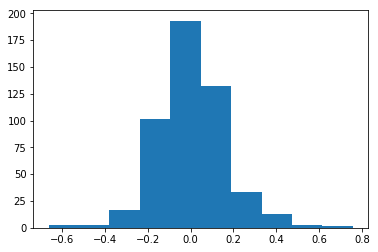

In [60]:
plt.hist(est[:, 0, 0, :])

In [324]:
df.to_csv("result.csv")

In [251]:
print(np.round(np.mean((est - theta) ** 2, axis=0), 4).flatten())
print(np.round(np.mean(coverage, axis=0), 3).flatten())
print(np.round(np.median(width, axis=0), 3).flatten())
m = iFusion(early_stopping_rounds = 20, cv_num = 10, tau = -1/3, epsilon = 0.1)
m.fit(X, y, target_id)

In [ ]:
def performance(mean_all, cov_all, truth, alpha = 0.05, rounding = 5, dist = "Gaussian"):
    p = len(theta)
    mse, coverage, width = [], [], []
    multiplier = norm.ppdf(1 - alpha)
    for j in range(p):
        mse.append(np.mean(np.square(mean_all[:, j] - truth[j])))
        ci_up = mean_all[:, j] + multiplier * np.sqrt(cov_all[:, j, j])
        ci_low = mean_all[:, j] - multiplier * np.sqrt(cov_all[:, j, j])
        coverage.append(np.mean(ci_up >= truth[j] and ci_low <= truth[j]))
        width.append(np.mean(multiplier * cov_all[:, j, j]))
    return mse, coverage, width

In [262]:
np.arange(9)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])